In [2]:
import pandas as pd
import gurobipy as gp
import gurobipy_pandas as gppd
import numpy as np
from itertools import product
from gurobipy import GRB
import scipy.sparse as sp
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.patches import FancyArrowPatch

In [3]:
data = pd.read_csv("assignment_files/assignment_1/Residential_areas.csv", header=None, names=["x", "y", "population"])
data.head()

,x,y,population
0,5,5,400
1,12,8,350
2,14,15,300
3,20,10,450
4,8,18,200


In [4]:
customers = []
facilities = []
possible_facilities = []
built_facilities = [(45, 46), (7, 10), (35, 8), (18, 35)]

for index, row in data.iterrows():
    x = int(row['x'])
    y = int(row['y'])
    location = (x, y)

    customers.append(location)
    facilities.append(location)

    if location not in built_facilities:
        possible_facilities.append(location)

n = len(customers) #=len(facilities)
v1 = len(possible_facilities)
v2 = len(built_facilities)

In [5]:
def manhattan_dist(location1, location2, x_stretch, y_stretch):
    return x_stretch * abs(location1[0] - location2[0]) + y_stretch * abs(location1[1] - location2[1])


def euclidean_dist(location1, location2):
    return np.sqrt(np.square(location1[0] - location2[0]) + np.square(location1[1] - location2[1]))


def create_incidence_matrix(customers, facilities, max_distance, x_stretch, y_stretch):
    A = np.zeros((len(customers), len(facilities)))
    for i, customer in enumerate(customers):
        for j, facility in enumerate(facilities):
            if manhattan_dist(customer, facility, x_stretch, y_stretch) <= max_distance:
                A[i][j] = 1
    return A

def relocation_cost(built_facility, possible_facility, fixed_cost, c):
    return fixed_cost + c * euclidean_dist(built_facility, possible_facility)

def relocation_cost_matrix(built_facilities, possible_facilities, fixed_cost, c):
    C = np.zeros((len(built_facilities), len(possible_facilities)))
    for i, built_facility in enumerate(built_facilities):
        for j, possible_facility in enumerate(possible_facilities):
            C[i][j] = relocation_cost(built_facility, possible_facility, fixed_cost, c)
    return C

def get_solution_locations(full_set, chosen_set):
    return [coord for coord, flag in zip(full_set, chosen_set) if flag == 1]

def get_relocated(built_facilities, possible_facilities, relocation_solution):
    from_here, to_here = [], []
    for i, possible_facility in enumerate(possible_facilities):
        for j, built_facility in enumerate(built_facilities):
            if relocation_solution[i][j] == 1:
                from_here.append(built_facility)
                to_here.append(possible_facility)
    return from_here, to_here

In [6]:
def plot_solution(all_locations, chosen_facilities, built_facilities, relocated_from, relocated_to):

    plt.figure(figsize=(8, 8))

    x_coords, y_coords = zip(*all_locations)
    plt.scatter(x_coords, y_coords, c='lightgrey', label='All Locations', s=25)
    

    if chosen_facilities != None:

        x_coords, y_coords = zip(*chosen_facilities)
        plt.scatter(x_coords, y_coords, c='red', label='Facilities We Chose To Construct', s=25)

        for x, y in chosen_facilities:
            rhombus_points = [(x, y + 15), (x + 15, y), (x, y - 15), (x - 15, y)]
            rhombus = Polygon(rhombus_points, edgecolor='red', facecolor='none', linewidth=2)
            plt.gca().add_patch(rhombus)


    if built_facilities != None:
        
        x_coords, y_coords = zip(*built_facilities)
        plt.scatter(x_coords, y_coords, c='blue', label='Already Built Facilities', s=25)

        for x, y in built_facilities:
            rhombus_points = [(x, y + 15), (x + 15, y), (x, y - 15), (x - 15, y)]
            rhombus = Polygon(rhombus_points, edgecolor='blue', facecolor='none', linewidth=2)
            plt.gca().add_patch(rhombus)


    if relocated_from != None and relocated_to != None:
        
        x_coords, y_coords = zip(*relocated_to)
        plt.scatter(x_coords, y_coords, c='green', s=25, label='Relocation of Facilities')
        
        x_coords, y_coords = zip(*relocated_from)
        plt.scatter(x_coords, y_coords, c='green', alpha=0.25, s=25)

        for (x_from, y_from), (x_to, y_to) in zip(relocated_from, relocated_to):
            
            arrow = FancyArrowPatch((x_from, y_from), (x_to, y_to), arrowstyle='->', color='green', linewidth=2, mutation_scale=20)
            plt.gca().add_patch(arrow)

            rhombus_points_to = [(x_to, y_to + 15), (x_to + 15, y_to), (x_to, y_to - 15), (x_to - 15, y_to)]
            rhombus_to = Polygon(rhombus_points_to, edgecolor='green', facecolor='none', linewidth=2)
            plt.gca().add_patch(rhombus_to)

            rhombus_points_from= [(x_from, y_from + 15), (x_from + 15, y_from), (x_from, y_from - 15), (x_from - 15, y_from)]
            rhombus_from = Polygon(rhombus_points_from, edgecolor='green', facecolor='none', linewidth=2, alpha=0.25)
            plt.gca().add_patch(rhombus_from)


    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('Coordinate Map')
    plt.axhline(0, color='black', linewidth=0.5)
    plt.axvline(0, color='black', linewidth=0.5)
    plt.grid(color='gray', linestyle='--', linewidth=0.5)
    plt.legend()
    plt.axis('equal')

    

Restricted license - for non-production use only - expires 2026-11-23
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.2.0 24C101)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 29 rows, 29 columns and 217 nonzeros
Model fingerprint: 0x8fcc4678
Variable types: 0 continuous, 29 integer (29 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 7.0000000
Presolve removed 29 rows and 29 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.00 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 2: 6 7 

Optimal solution found (tolerance 1.00e-04)
Best objective 6.000000000000e+00, best bound 6.000000000000e+00, gap 0.0000%


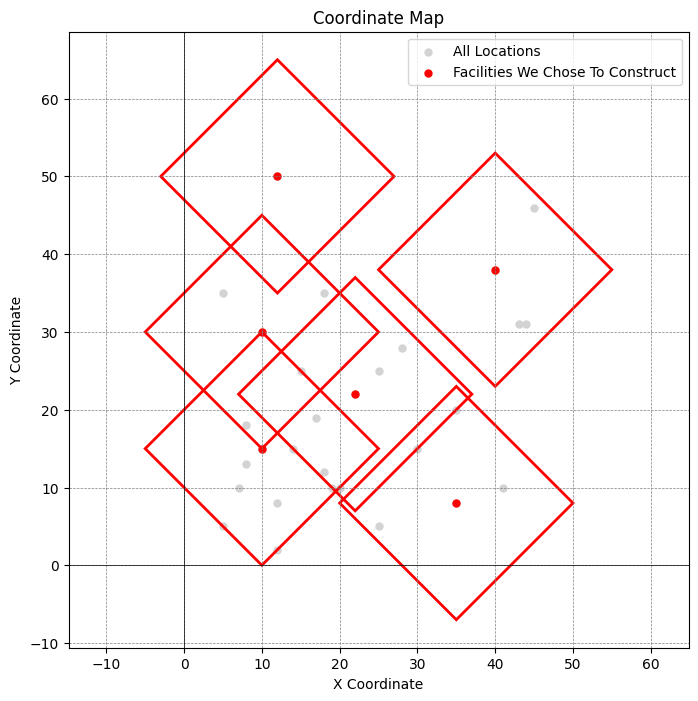

In [7]:
model1 = gp.Model("Exercise 1")

A = create_incidence_matrix(customers=customers, facilities=facilities, max_distance=15, x_stretch=1, y_stretch=1)

x = model1.addMVar(n, vtype=GRB.BINARY, name="x")
model1.addConstr(A @ x >= 1)
model1.setObjective(x.sum(), sense=GRB.MINIMIZE)

model1.update()
model1.optimize()

chosen_facilities = get_solution_locations(full_set=facilities, chosen_set=x.X)
plot_solution(all_locations=customers,
              chosen_facilities=chosen_facilities,
              built_facilities=None,
              relocated_from=None,
              relocated_to=None)

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.2.0 24C101)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 29 rows, 25 columns and 195 nonzeros
Model fingerprint: 0xbb43d99d
Variable types: 0 continuous, 25 integer (25 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 3.0000000
Presolve removed 29 rows and 25 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.00 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 1: 3 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.000000000000e+00, best bound 3.000000000000e+00, gap 0.0000%


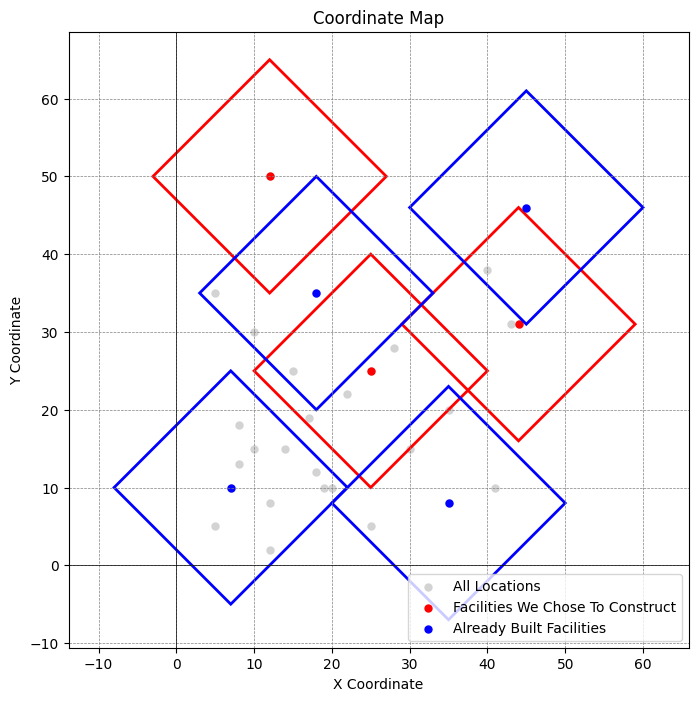

In [8]:
model2 = gp.Model("Exercise 4")

A1 = create_incidence_matrix(customers=customers, facilities=possible_facilities, max_distance=15, x_stretch=1, y_stretch=1)
A2 =  create_incidence_matrix(customers=customers, facilities=built_facilities, max_distance=15, x_stretch=1, y_stretch=1)

x = model2.addMVar(v1, vtype=GRB.BINARY, name='x')
model2.addConstr(A1 @ x + A2.sum(axis=1) >= 1)
model2.setObjective(x.sum(), sense=GRB.MINIMIZE)
model2.update()
model2.optimize()

chosen_facilities = get_solution_locations(full_set=possible_facilities, chosen_set=x.X)
plot_solution(all_locations=customers,
              chosen_facilities=chosen_facilities,
              built_facilities=built_facilities,
              relocated_from=None,
              relocated_to=None)

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.2.0 24C101)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 58 rows, 154 columns and 471 nonzeros
Model fingerprint: 0x943dcb25
Variable types: 0 continuous, 154 integer (154 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 124971.00000
Presolve removed 48 rows and 131 columns
Presolve time: 0.00s
Presolved: 10 rows, 23 columns, 42 nonzeros
Found heuristic solution: objective 54817.194340
Variable types: 0 continuous, 23 integer (23 binary)
Found heuristic solution: objective 49902.097170

Root relaxation: objective 1.490910e+04, 0 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent

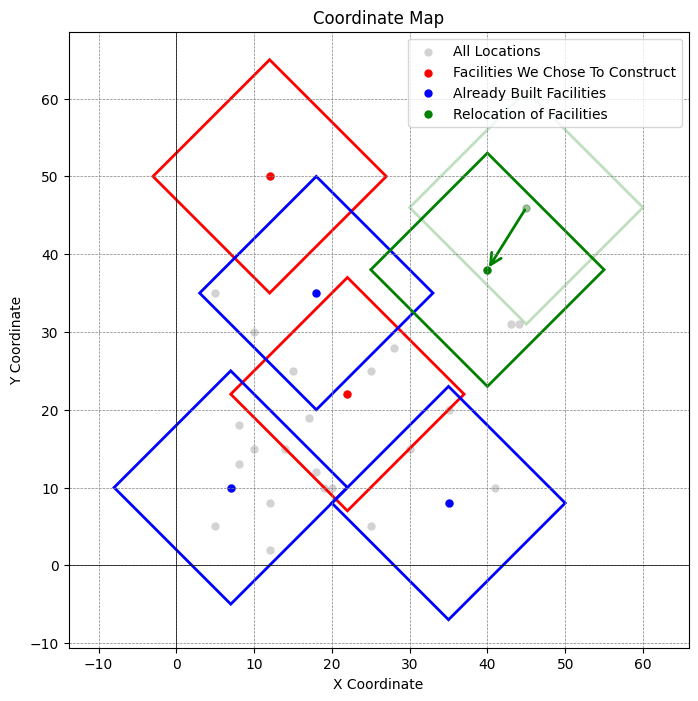

In [9]:
model3 = gp.Model("Exercise 7")

C = relocation_cost_matrix(built_facilities=built_facilities, possible_facilities=possible_facilities, fixed_cost=3500, c=150)
building_cost = 5000
epsilon = 1

x_new = model3.addMVar(v1, vtype=GRB.BINARY, name='x_new')
x_built = model3.addMVar(v2, vtype=GRB.BINARY, name='x_built')
x_relocate = model3.addMVar((v1, v2), vtype=GRB.BINARY, name='x_relocate')
x_construct = model3.addMVar(v1, vtype=GRB.BINARY, name='x_construct')

model3.addConstr(A1 @ x_new + A2 @ x_built >=  1)
model3.addConstr(x_relocate.sum(axis=0) <= 1 - x_built)
model3.addConstr(x_relocate.sum(axis=1) + x_construct >= x_new)
model3.setObjective((C.transpose() * x_relocate).sum() + building_cost * x_construct.sum() - epsilon * (x_new.sum() + x_built.sum()), sense=GRB.MINIMIZE)

model3.update()
model3.optimize()

chosen_facilities = get_solution_locations(full_set=possible_facilities, chosen_set=x_construct.X)
built_facilities_active = get_solution_locations(full_set=built_facilities, chosen_set=x_built.X)
relocated_from, relocated_to = get_relocated(built_facilities=built_facilities, possible_facilities=possible_facilities, relocation_solution=x_relocate.X)

plot_solution(all_locations=customers,
              chosen_facilities=chosen_facilities, 
              built_facilities=built_facilities_active,
              relocated_from=relocated_from,
              relocated_to=relocated_to)



Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.2.0 24C101)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 58 rows, 870 columns and 1087 nonzeros
Model fingerprint: 0x72986db9
Variable types: 841 continuous, 29 integer (29 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+02, 6e+02]
Found heuristic solution: objective 18.0000000
Presolve removed 11 rows and 643 columns
Presolve time: 0.00s
Presolved: 47 rows, 227 columns, 430 nonzeros
Found heuristic solution: objective 17.0000000
Variable types: 203 continuous, 24 integer (24 binary)

Root relaxation: objective 7.300000e+00, 75 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  

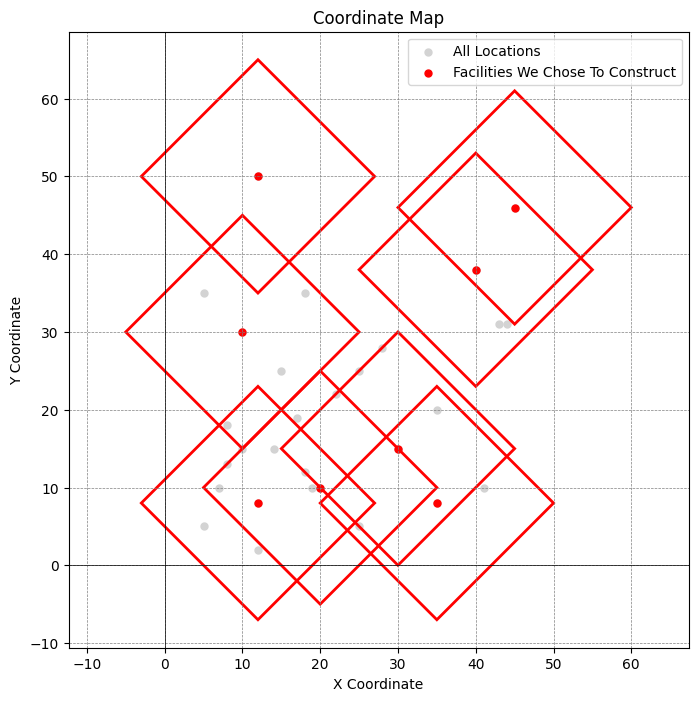

In [10]:
model4 = gp.Model()

k = 2000
A = create_incidence_matrix(customers=customers, facilities=facilities, max_distance=15, x_stretch=1, y_stretch=1)
p = np.asarray(data['population'])

s = model4.addMVar((n, n), lb=0)
y = model4.addMVar(n, vtype=GRB.BINARY)

model4.addConstr((A * s).sum(axis=1) == p)
model4.addConstr(s.sum(axis=0) <= k * y)
model4.setObjective(y.sum(), sense=GRB.MINIMIZE)

model4.update()
model4.optimize()

chosen_facilities = get_solution_locations(full_set=facilities, chosen_set=y.X)
plot_solution(all_locations=customers,
              chosen_facilities=chosen_facilities,
              built_facilities=None,
              relocated_from=None,
              relocated_to=None)


In [11]:
latex_table = r"""
\begin{table}[h]
    \centering
    \caption{Optimal Allocation with K=1000}
    \begin{tabular}{|c|c|l|l|}
    \hline
    \textbf{Facility} & \textbf{Residential Area} & \textbf{Amount Covered} & \textbf{From Total Population} \\
    
"""

for i, facility in enumerate(facilities):
    usage = s.X[:, i].sum()
    if usage > 0:
        latex_table += f"\\hline \n    {facility} & & {usage} & \\\\\n \\hline \n"

        for j, customer in enumerate(customers):
            if s.X[j][i] > 0:
                latex_table += f"    & {customer} & {s.X[j][i]} & {p[j]} \\\\\n"



latex_table += r"""
    \hline
    \end{tabular}
\end{table}
"""



print(latex_table)


\begin{table}[h]
    \centering
    \caption{Optimal Allocation with K=1000}
    \begin{tabular}{|c|c|l|l|}
    \hline
    \textbf{Facility} & \textbf{Residential Area} & \textbf{Amount Covered} & \textbf{From Total Population} \\
    
\hline 
    (12, 8) & & 2000.0 & \\
 \hline 
    & (5, 5) & 400.0 & 400 \\
    & (12, 8) & 150.0 & 350 \\
    & (20, 10) & 450.0 & 450 \\
    & (12, 2) & 300.0 & 300 \\
    & (19, 10) & 350.0 & 350 \\
    & (7, 10) & 350.0 & 350 \\
\hline 
    (20, 10) & & 2000.0 & \\
 \hline 
    & (12, 8) & 200.0 & 350 \\
    & (14, 15) & 300.0 & 300 \\
    & (18, 12) & 200.0 & 300 \\
    & (30, 15) & 250.0 & 500 \\
    & (22, 22) & 500.0 & 500 \\
    & (17, 19) & 300.0 & 300 \\
    & (8, 13) & 250.0 & 250 \\
\hline 
    (30, 15) & & 2000.0 & \\
 \hline 
    & (18, 12) & 100.0 & 300 \\
    & (35, 8) & 600.0 & 600 \\
    & (28, 28) & 400.0 & 400 \\
    & (35, 20) & 450.0 & 450 \\
    & (25, 25) & 450.0 & 450 \\
\hline 
    (35, 8) & & 950.0 & \\
 \hline 
    & (25, 5) 